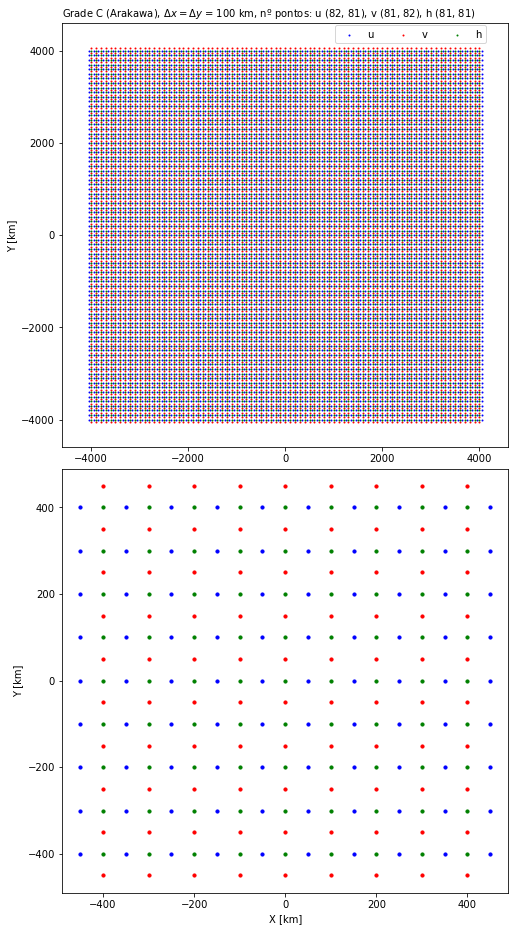

In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import imageio.v2 as imageio
from functions import *
import os

# C-grid Arakawa, design
Nx, Ny = 80, 80
y, yv, Xu, Yu, Xv, Yv, Xh, Yh, dx, dy = plot_gridC(Nx, Ny)



In [3]:
# Physics parameters --------------------------------
g = 9.80665         # Gravity acceleration [m/s^2]
H = 250            # Height of the fluid [m]
c = np.sqrt(g*H)    # Velocity phase [m/s]

# Conditions
Nt, dt, lat, Nrx, Nry  = 1000, 540, -20, 4, 4
"""
scen1: f=0
scen2: f at -20 degrees as lat
scen3: beta variation between -4000 to 4000
dx: 100 km = 100*1e3
dy: 100 km = 100*1e3
"""
rad = True          # radiational
scen = 'scen1'
print("CFL: {:.2f}".format(c*dt/dx))

if c*dt/dx <= 0.35: 
    u, v, h, Fu, f, beta, div, vor = conditions(scen, Xu, Yu, Xh, Yh, yv, 
                                                lat, Nx, Ny, dx, dy, Nt, Nrx, Nry)
    
    u, v, h, div, vor = leapfrog(scen, Nt, u, v, h, g, dx, dy, dt,
                                 H, Fu, f, beta, y, yv, c, div, vor, rad)
    
    print("Computation " + scen + " done!")
else:
    print("Oops! CFL > 0.35. Reduce dt or increase dx, dy")

print("Courant number {:.2f}".format(c*dt/dx))
print("Phase velocity (c): {:.2f}".format(c))

CFL: 0.27
Computation scen1 done!
Courant number 0.27
Phase velocity (c): 49.51


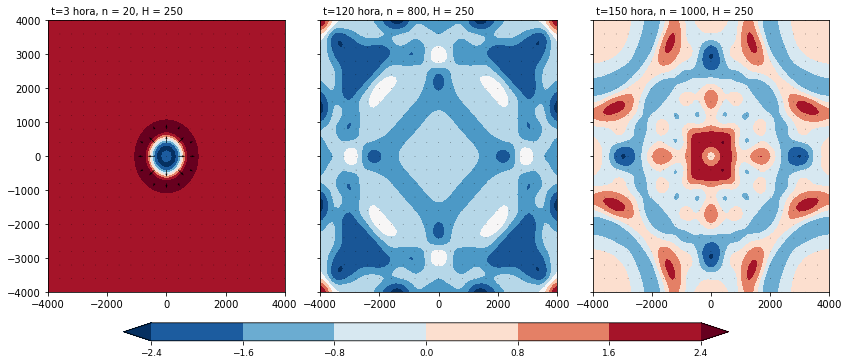

In [7]:
# Arrows
arrow = 0.01
staged_u = np.zeros((Nt+1, Nx+1, Ny+1))
staged_v = np.zeros((Nt+1, Nx+1, Ny+1))

titles = ['f = 0', 'f em -20°S', 'Beta equatorial']
    
fig, axes = plt.subplots(1,3, figsize=(14,5), sharex=True, sharey=True, 
                         gridspec_kw={'wspace':0.15, 'hspace':0.15} )
for ax, n in zip(axes.flatten(), [20, 800, 1000]):
    im = ax.contourf(Xh/1000,Yh/1000, h[n,:,:], cmap=plt.cm.RdBu_r,  extend='both') 
    #cbar = fig.colorbar(im, ax=ax, orientation="vertical")
    staged_u[:, :, :] = (u[:, 1:, :] + u[:, :-1, :]) * 0.5
    staged_v[:, :, :] = (v[:, :, 1:] + v[:, :, :-1]) * 0.5
    ax.quiver(Xh[::4, ::4]/1000, Yh[::4, ::4]/1000, staged_u[n,::4, ::4], staged_v[n,::4, ::4],
              units = "xy", scale = arrow)
    #qk = ax.quiverkey(Q, 0.9, 0.8, 1000, "0.1 m/s", labelpos = "E", coordinates = "figure")
    ax.set_title(" t={:.0f} hora, n = {:.0f}, H = {:.0f}".format(dt*n/3600, n, H), fontsize=10, loc='left')
cax = fig.add_axes([.2,-.01,0.6,.05]) # left, bottom, width, height
cbar = fig.colorbar(im, cax=cax, orientation='horizontal') # pad, shrink
cbar.ax.tick_params(labelsize=9)

In [8]:
# animation
# ---------
lvs = list(np.linspace(-10,10,100))

filenames = []
# plot the line chart

for n in range(1,Nt,6):
    fig, ax = plt.subplots()
    im = ax.contourf(Xh/1000, Yh/1000, h[n,:,:], cmap=plt.cm.RdBu_r, levels=lvs, extend='both')
    fig.colorbar(im, ax=ax, orientation="vertical")
    ax.set_title("t={:.0f} hora, passo de tempo = {:.0f}".format(dt*n/3600, n), fontsize=10, loc='left')
    ax.quiver(Xh[::4, ::4]/1000, Yh[::4, ::4]/1000, u[n,::4, ::4], v[n,::4, ::4],
              units = "xy", scale = arrow)

    # create file name and append it to a list
    filename = f'fig/gifs/{n}.png'
    filenames.append(filename)

    # save frame
    fig.savefig(filename, dpi=200)
    plt.close() # build gif

if rad == True:
    cf = 'rad'

else:
    cf = 'rig'

with imageio.get_writer('gifs/leap_teste_'+cf+'_'+str(H)+'m_'+scen+'.gif', mode='I', duration = 0) as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)

# Remove files
for filename in set(filenames):
    os.remove(filename)